In [1]:
import sys
from operator import add
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import StopWordsRemover
import pyspark.sql.functions as f
import pandas as pd
import os
import glob
from wordcloud import STOPWORDS, WordCloud
import matplotlib.pyplot as plt

In [2]:
spark = SparkSession\
.builder\
.appName("Wordcount")\
.getOrCreate()

In [7]:
path = './dataset_oscar/'
all_files = glob.glob(os.path.join(path, "dataset_oscar*.csv"))
all_files

['./dataset_oscar/dataset_oscar10.csv',
 './dataset_oscar/dataset_oscar3.csv',
 './dataset_oscar/dataset_oscar1.csv',
 './dataset_oscar/dataset_oscar2.csv',
 './dataset_oscar/dataset_oscar6.csv',
 './dataset_oscar/dataset_oscar7.csv',
 './dataset_oscar/dataset_oscar5.csv',
 './dataset_oscar/dataset_oscar8.csv',
 './dataset_oscar/dataset_oscar4.csv',
 './dataset_oscar/dataset_oscar9.csv']

In [45]:
data = spark.read.format('csv').options(header='true', inferSchema='true').load(all_files)
data.show()

+---------+-------------+--------+--------------------+------------------+--------------------+------+
|year_film|year_ceremony|ceremony|            category|              name|                film|winner|
+---------+-------------+--------+--------------------+------------------+--------------------+------+
|     1937|         1938|      10|               ACTOR|     Charles Boyer|            Conquest| False|
|     1937|         1938|      10|               ACTOR|     Fredric March|      A Star Is Born| False|
|     1937|         1938|      10|               ACTOR| Robert Montgomery|     Night Must Fall| False|
|     1937|         1938|      10|               ACTOR|         Paul Muni|The Life of Emile...| False|
|     1937|         1938|      10|               ACTOR|     Spencer Tracy| Captains Courageous|  True|
|     1937|         1938|      10|ACTOR IN A SUPPOR...|     Ralph Bellamy|     The Awful Truth| False|
|     1937|         1938|      10|ACTOR IN A SUPPOR...|   Thomas Mitchell

In [46]:
data.withColumn('word', f.explode(f.split(f.col('film'), ' '))) \
  .groupBy('word') \
  .count() \
  .sort('count', ascending=False) \
  .show(10)

+----+-----+
|word|count|
+----+-----+
| The| 2539|
|  of| 1224|
| the| 1097|
| and|  460|
|   A|  308|
|  in|  271|
|   a|  254|
|  to|  233|
|  on|  148|
| Man|  144|
+----+-----+
only showing top 10 rows



In [47]:
data = data.na.drop()

In [48]:
tokenizer = Tokenizer(inputCol='film', outputCol="words_tokens")
tokenized = tokenizer.transform(data).select('words_tokens')
tokenized.show()

+--------------------+
|        words_tokens|
+--------------------+
|          [conquest]|
| [a, star, is, born]|
| [night, must, fall]|
|[the, life, of, e...|
|[captains, courag...|
| [the, awful, truth]|
|    [the, hurricane]|
|[the, life, of, e...|
|     [lost, horizon]|
|            [topper]|
| [the, awful, truth]|
|           [camille]|
| [a, star, is, born]|
|  [the, good, earth]|
|    [stella, dallas]|
|  [in, old, chicago]|
|       [stage, door]|
|    [stella, dallas]|
|         [dead, end]|
| [night, must, fall]|
+--------------------+
only showing top 20 rows



In [49]:
remover = StopWordsRemover(inputCol='words_tokens', outputCol='words_clean')
data_clean = remover.transform(tokenized).select('words_clean')
data_clean.show()

+--------------------+
|         words_clean|
+--------------------+
|          [conquest]|
|        [star, born]|
| [night, must, fall]|
| [life, emile, zola]|
|[captains, courag...|
|      [awful, truth]|
|         [hurricane]|
| [life, emile, zola]|
|     [lost, horizon]|
|            [topper]|
|      [awful, truth]|
|           [camille]|
|        [star, born]|
|       [good, earth]|
|    [stella, dallas]|
|      [old, chicago]|
|       [stage, door]|
|    [stella, dallas]|
|         [dead, end]|
| [night, must, fall]|
+--------------------+
only showing top 20 rows



+--------------------+
|         words_clean|
+--------------------+
|          [conquest]|
|        [star, born]|
| [night, must, fall]|
| [life, emile, zola]|
|[captains, courag...|
|      [awful, truth]|
|         [hurricane]|
| [life, emile, zola]|
|     [lost, horizon]|
|            [topper]|
|      [awful, truth]|
|           [camille]|
|        [star, born]|
|       [good, earth]|
|    [stella, dallas]|
|      [old, chicago]|
|       [stage, door]|
|    [stella, dallas]|
|         [dead, end]|
| [night, must, fall]|
+--------------------+
only showing top 20 rows



In [51]:
result = data_clean.withColumn('word', f.explode(f.col('words_clean'))) \
  .groupBy('word') \
  .count().sort('count', ascending=False) 
result.show(10)

+------+-----+
|  word|count|
+------+-----+
|   man|  144|
| story|  125|
|  love|  110|
|  life|  103|
|  star|   88|
|little|   75|
|  girl|   72|
|    la|   68|
|   day|   67|
|  king|   67|
+------+-----+
only showing top 10 rows



In [22]:
combined_csv = pd.concat([pd.read_csv(f) for f in all_files ])
combined_csv.to_csv( "all_csv.csv", index=False )


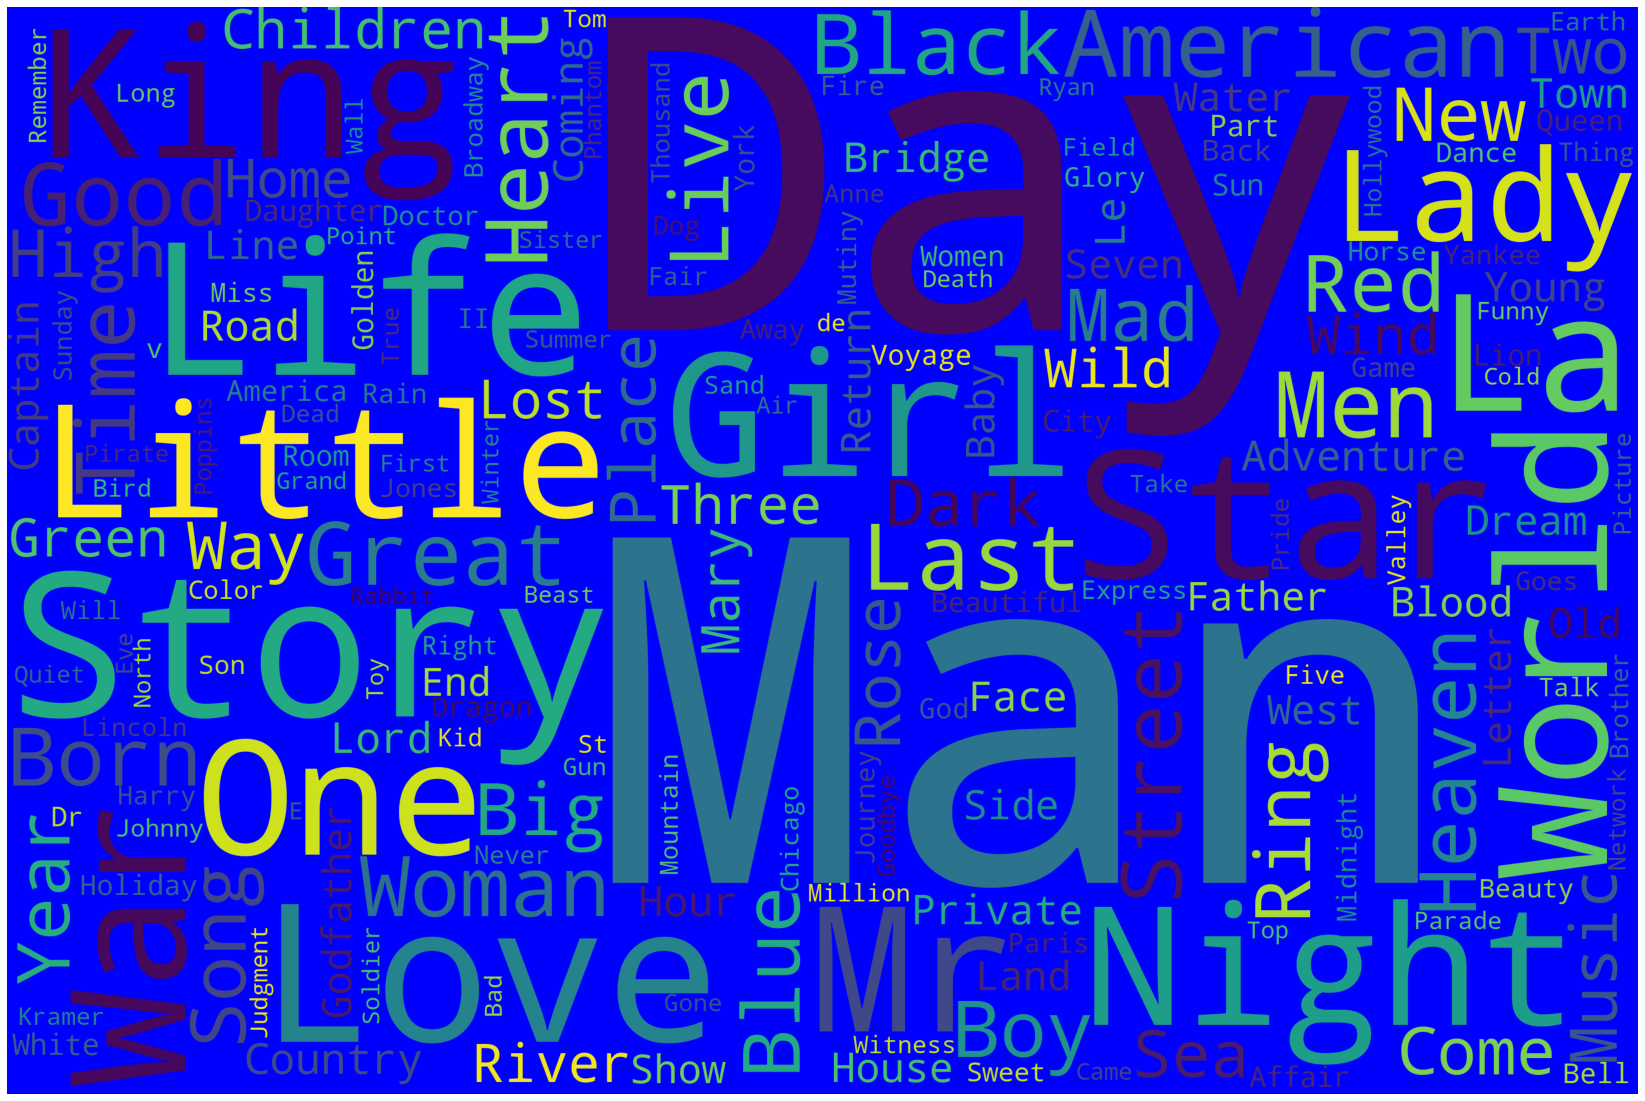

In [54]:
oscar = pd.read_csv('all_csv.csv', sep=',').dropna()
text = oscar.film.to_json()
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='blue', collocations=False, stopwords = STOPWORDS).generate(text)
plt.figure(figsize=(30, 20))

plt.imshow(wordcloud) 

plt.axis("off")
plt.show()